In [1]:
import os
import scipy.io.wavfile as wav

def mp32np(filename):
    temp_wav = 'data/temp.wav'
    cmd = 'lame --decode {0} {1}'.format( filename, temp_wav) 
    os.system(cmd)
    Fs, data_list = wav.read(temp_wav)
    data = np.array(data_list)
    os.remove(temp_wav)
    return data, Fs

In [3]:
import numpy as np
input_filename = './data/cello/cello_C4_1_forte_arco-normal.mp3'
data, Fs = mp32np(input_filename)
n = len(data)
t = np.arange(0,n/Fs,1/Fs)

In [4]:
import sounddevice as sd
sd.play(data, Fs)

In [5]:
data.shape, t

((59375,), array([0.00000000e+00, 2.26757370e-05, 4.53514739e-05, ...,
        1.34630385e+00, 1.34632653e+00, 1.34634921e+00]))

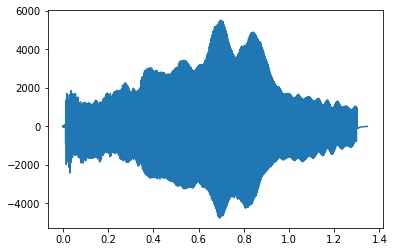

In [7]:
import matplotlib.pyplot as plt

plt.plot(t, data)
plt.show()

# Feature 1: The Fast Fourier Transform Coefficients
* Maybe we need to split the converted audio data into frames? (e.g. 1024 frames)
* Then get the FFCT of each frame?

In [8]:
import numpy.fft as fft

def get_fftc(data):

    n = len(data)
    
    k = np.arange(n)
    T = n/Fs

    data_freq = k/T
    data_freq = data_freq[range(int(n/2))]

    data_fft = fft.fft(data)/n
    data_fft = data_fft[range(int(n/2))]
    
    return data_fft, data_freq

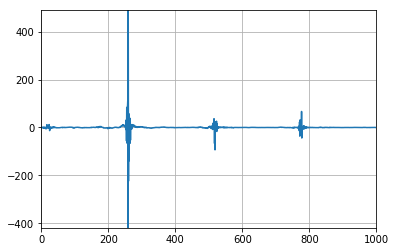

In [9]:
data_fft, data_freq = get_fftc(data)
plt.plot(data_freq, data_fft.real)
plt.axis([0,1000, min(data_fft.real), max(data_fft.real)])
plt.grid(which='both')
plt.show()

In [10]:
# Find the peak in the coefficients
def find_fundamental_freq(data_fft):
    idx = np.argmax(np.abs(data_fft))
    freq = data_freq[idx]
    freq_in_hertz = abs(freq)
    print(freq_in_hertz)
    return freq_in_hertz

Pitch-shifting:
http://zulko.github.io/blog/2014/03/29/soundstretching-and-pitch-shifting-in-python/

In [11]:
import numpy as np

def speedx(sound_array, factor):
    """ Multiplies the sound's speed by some `factor` """
    indices = np.round( np.arange(0, len(sound_array), factor) )
    indices = indices[indices < len(sound_array)].astype(int)
    return sound_array[ indices.astype(int) ]

def stretch(sound_array, f, window_size, h):
    """ Stretches the sound by a factor `f` """

    phase  = np.zeros(window_size)
    hanning_window = np.hanning(window_size)
    result = np.zeros( int(len(sound_array) /f) + window_size, dtype='complex128')

    for i in np.arange(0, len(sound_array)-(window_size+h), int(h*f)):
        # two potentially overlapping subarrays
        a1 = sound_array[i: i + window_size]
        a2 = sound_array[i + h: i + window_size + h]

        # resynchronize the second array on the first
        s1 =  np.fft.fft(hanning_window * a1)
        s2 =  np.fft.fft(hanning_window * a2)
        phase = (phase + np.angle(s2/s1)) % 2*np.pi
        a2_rephased = np.fft.ifft(np.abs(s2)*np.exp(1j*phase))

        # add to result
        i2 = int(i/f)
        result[i2 : i2 + window_size] += hanning_window*a2_rephased

    result = ((2**(16-4)) * result/result.max()) # normalize (16bit)

    return result.astype('int16')

def pitchshift(snd_array, n, window_size=2**13, h=2**11):
    """ Changes the pitch of a sound by ``n`` semitones. """
    factor = 2**(1.0 * n / 12.0)
    stretched = stretch(snd_array, 1.0/factor, window_size, h)
    return speedx(stretched[window_size:], factor)

In [12]:
x_a4 = pitchshift(data, 9)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


In [13]:
import sounddevice as sd
sd.play(data, Fs)
sd.play(x_a4, Fs)

In [14]:
def get_shifted_fftc(data, data_pitch, cutoff_freq=2000):
    
    scale = ["a2", "as2", "b2",
         "c3", "cs3", "d3", "ds3", "e3", "f3", "fs3", "g3", "gs3", "a3", "as3", "b3",
         "c4", "cs4", "d4", "ds4", "e4", "f4", "fs4", "g4", "gs4", "a4", "as4", "b4",
         "c5", "cs5", "d5", "ds5", "e5", "f5", "fs5", "g5", "gs5", "a5", "as5", "b5",
         "c6", "cs6", "d6", "ds6", "e6", "f6", "fs6", "g6", "gs6", "a6", "as6", "b6"
        ]
    
    REF_PITCH = "a4"
    semitones_to_shift = scale.index(REF_PITCH.lower()) - scale.index(data_pitch.lower())
    
    data_pitchshifted = pitchshift(data, semitones_to_shift)
    
    n = len(data_pitchshifted)
    k = np.arange(n)
    T = n/Fs

    data_freq = k/T
    data_freq = [x for x in data_freq if x <= cutoff_freq]
    
    data_fft = fft.fft(data_pitchshifted)/n
    data_fft = data_fft[range(len(data_freq))]
    
    return data_fft, data_freq

USAGE!!

In [52]:
import os
#input_filename = './data/clarinet/clarinet_B3_025_forte_normal.mp3'
input_filename = './data/guitar/guitar_C4_very-long_forte_normal.mp3'
#input_filename = './data/guitar/guitar_E4_very-long_forte_normal.mp3'
data_pitch = os.path.basename(input_filename).split('_')[1].lower()
data_fft_shifted, data_freq_shifted = get_shifted_fftc(data, data_pitch)
print(len(data_fft_shifted))

2693


C:\anaconda3\lib\site-packages\ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


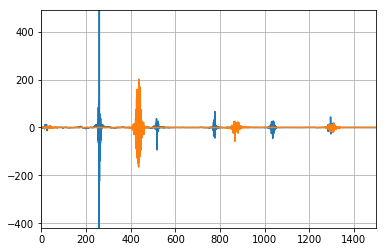

In [53]:
# Compare freq plot with un-shifted
data_fft, data_freq = get_fftc(data)

plt.plot(data_freq, data_fft.real, data_freq_shifted, data_fft_shifted.real)
plt.axis([0,1500, min(data_fft.real), max(data_fft.real)])
plt.grid(which='both')
plt.show()

In [54]:
def reduce_to_mag_bins(data, n_bins=50):
    n_samples_per_bin = int(len(data)/n_bins)+1
    #print(len(data),n_samples_per_bin)
    
    bins = np.zeros((n_bins,1))
    
    for i in range(n_bins):
        lower = i*(n_samples_per_bin)
        upper = (i+1)*n_samples_per_bin-1
        if upper > len(data):
            upper = -1
            
        bins[i] = abs(np.mean(data[lower:upper]))
        
    return bins
    

In [55]:
bins = reduce_to_mag_bins(data_fft_shifted)

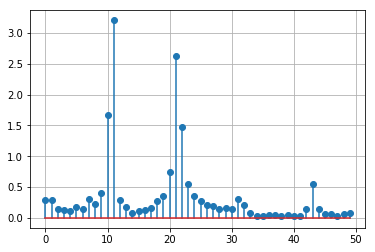

In [56]:
plt.stem(bins)
plt.grid(which='both')
plt.savefig(os.path.basename(input_filename)+'_fig.png')
plt.show()

# Feature 2: Real Cepstral Coefficients (RCEP)

# Feature 3: Mel-Frequency Cepstral Coefficients (MFCC)

# Feature 4: Zero Crossing Rate

# Feature 5: Spectral Spread, Spectral Centroid, Spectral Roll-off

# Feature 6: Autoregression Coefficients (LPC)